# 匯入模組、資料

In [1]:
# 載入模組
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# 載入資料
df = pd.read_csv("retailer_data.csv",encoding="utf-8")
df.head()

,customer_id,customer_name,gender,invoice_no,invoice_date,invoice_time,product_name,product_code,unit_price,quantity,subtotal,region_id,region_name,category_name,date_time
0,16446,name,Female,581483,2019-12-07,09:15:00,中興米外銷日本之米(圓ㄧ)3Kg,23843,169,285,48165,333,龜山區,米油沖泡_米．食用油_食用米_米,2019-12-07 09:15:00
1,12346,name,Female,541431,2019-01-16,10:01:00,樂米穀場花東自然農耕特哉鮮白米(圓二)1.5K,23166,189,272,51408,328,觀音區,米油沖泡_米．食用油_食用米_米,2019-01-16 10:01:00
2,12901,name,Male,573008,2019-10-25,12:26:00,一匙靈Attack抗菌EX洗衣精補充-1.5Kg,84077,79,69,5451,337,大園區,日用百貨_家庭清潔_洗衣用品_洗衣精,2019-10-25 12:26:00
3,13135,name,Female,554868,2019-05-25,10:52:00,鴻津太國捲(蛋奶素)-370g,22197,88,66,5808,335,大溪區,飲料零食_精選餅乾_鹹餅乾_米果,2019-05-25 10:52:00
4,18087,name,Female,544612,2019-02-20,10:43:00,IQ Dog 成犬乾狗糧-羊肉13.5kg,22053,409,62,25358,326,楊梅區,生活休閒_寵物用品_狗_狗乾糧．罐頭,2019-02-20 10:43:00


## 做User-Category Table

In [3]:
# 只取大種類
df['category_name'] = df['category_name'].apply(lambda x : x.split('_')[0])

In [4]:
# 計算每個user 買了什麼種類
user_category_df = df.groupby('customer_id').agg({'category_name':lambda x : dict(Counter(' '.join(x).split(' ')))})
user_category_df.head()

,category_name
customer_id,
1,"{'生鮮食品': 59, '冷凍食品': 28, '生活休閒': 101, '飲料零食': ..."
2,"{'生活休閒': 1, '米油沖泡': 1}"
3,{'生鮮食品': 1}
4,"{'飲料零食': 1, '生活休閒': 1}"
5,"{'生鮮食品': 77, '飲料零食': 55, '生活休閒': 123, '冷凍食品': ..."


In [5]:
def get_user_category_df(df):
    
    # 建造customerID的list, 並去掉重複值
    customer_id_list = df['customer_id'].tolist()
    customer_id_list = list(set(customer_id_list))
    
    tmp_category_df = pd.DataFrame(data = user_category_df['category_name'][1], index=['first'])
    for user in customer_id_list:   
        user_dict = user_category_df['category_name'][user]
        user_df = pd.DataFrame(data = user_dict, index=[user])
        tmp_category_df = tmp_category_df.append(user_df)
    tmp_category_df.drop(index = 'first',inplace=True)
    tmp_category_df = tmp_category_df.fillna(0)
    
    return tmp_category_df
user_category_df = get_user_category_df(df)

# 新增'customer_id欄位'
user_category_df['customer_id'] = user_category_df.index
user_category_df.reset_index(drop=True, inplace=True)
user_category_df.head()

,生鮮食品,冷凍食品,生活休閒,飲料零食,米油沖泡,服飾鞋包,日用百貨,美妝護理,母嬰保健,大小家電,傢俱寢飾,3C,customer_id
0,59.0,28.0,101.0,53.0,107.0,23.0,54.0,61.0,6.0,18.0,6.0,6.0,1
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,77.0,26.0,123.0,55.0,102.0,26.0,63.0,66.0,11.0,22.0,10.0,8.0,5


#  做RFM Table

In [6]:
# 找出最近的日期
print(df['invoice_date'].max())

# 將日期的資料型態從 string 轉成 datetime
df['invoice_date']=pd.to_datetime(df['invoice_date'], format = '%Y-%m-%d %H:%M:%S')

2019-12-07


In [7]:
#計算 recency and frequency
import datetime as dt
NOW = dt.datetime(2019,12,8)

In [8]:
# frequency table
frequency_df = df.drop_duplicates(['invoice_no']).groupby('customer_id', as_index=False).agg({'invoice_no' : lambda x : len(x)})
frequency_df.head()

,customer_id,invoice_no
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [9]:
# rfm_df最近消費次數 與 消費總金額 table
rfm_df = df.groupby('customer_id', as_index=False).agg({'invoice_date': lambda x: (NOW - x.max()).days,'subtotal': lambda x: x.sum()})

# 最近消費天數換成數字型態
rfm_df['invoice_date'] = rfm_df['invoice_date'].astype(int)

# 換成正確名稱
rfm_df.rename(columns={'invoice_date': 'recency', 'subtotal': 'monetary_value'}, inplace=True)

# 新增frequency欄位
rfm_df['frequency'] = frequency_df['invoice_no']
rfm_df.head()

,customer_id,recency,monetary_value,frequency
0,1,374,205050,1
1,2,374,740,1
2,3,374,230,1
3,4,374,152,1
4,5,374,328641,1


In [10]:
# 根據frequency and monetary values 的排名，找出Top 10的消費者 VIP們～
# Sorting first on frequency and then on Monetary value
rfm_df.sort_values(['frequency', 'monetary_value'], ascending=[False, False]).head()

,customer_id,recency,monetary_value,frequency
1699,12748,1,3132147,206
3252,14911,2,6041139,198
5381,17841,2,4718865,124
1935,13089,3,1509756,97
3549,15311,1,2026729,91


#  做User-Information Table

In [11]:
# 建立user_information Dataframe
data = {'customer_id':list(df['customer_id']),
       'region_name':list(df['region_name']),
       'gender':list(df['gender'])}
user_information_df = pd.DataFrame(data).drop_duplicates(ignore_index=True)
user_information_df.head()

,customer_id,region_name,gender
0,16446,龜山區,Female
1,12346,觀音區,Female
2,12901,大園區,Male
3,13135,大溪區,Female
4,18087,楊梅區,Female


In [12]:
# 非數值型態轉換成數字
def convert_nonNumeric_to_number(df,column_name):
    # 建立 {欄位名稱 : 數字} 的字典
    factor_list = list(set(df[column_name]))
    number_list = list(range(len(factor_list)))
    factor_number_dict = dict(zip(factor_list,number_list))
    
    # 印出字典,供檢查用
    print(factor_number_dict)
    
    # 將欄位名稱換成對應的數字
    df[column_name] = df[column_name].apply(lambda x : factor_number_dict[x])
    return df

user_information_df = convert_nonNumeric_to_number(user_information_df, 'region_name')
user_information_df = convert_nonNumeric_to_number(user_information_df, 'gender')
user_information_df.head()

{'大園區': 0, '中壢區': 1, '新屋區': 2, '八德區': 3, '龍潭區': 4, '平鎮區': 5, '蘆竹區': 6, '桃園區': 7, '楊梅區': 8, '龜山區': 9, '大溪區': 10, '復興區': 11, '觀音區': 12}
{'Female': 0, 'Male': 1}


,customer_id,region_name,gender
0,16446,9,0
1,12346,12,0
2,12901,0,1
3,13135,10,0
4,18087,8,0


In [13]:
# 將region, gender 轉成one hot encoding
user_information_df = pd.get_dummies(user_information_df,columns = ['region_name','gender'])
user_information_df.head()

,customer_id,region_name_0,region_name_1,region_name_2,region_name_3,region_name_4,region_name_5,region_name_6,region_name_7,region_name_8,region_name_9,region_name_10,region_name_11,region_name_12,gender_0,gender_1
0,16446,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,12346,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,12901,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,13135,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,18087,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [14]:
# 區域與性別換成相對應的名稱
user_information_df.rename(columns = {'region_name_0':'大園區',
                                      'region_name_1':'觀音區',
                                      'region_name_2':'龜山區',
                                      'region_name_3':'中壢區',
                                      'region_name_4':'龍潭區',
                                      'region_name_5':'蘆竹區',
                                      'region_name_6':'八德區',
                                      'region_name_7':'復興區',
                                      'region_name_8':'桃園區',
                                      'region_name_9':'大溪區',
                                      'region_name_10':'新屋區',
                                      'region_name_11':'楊梅區',
                                      'region_name_12':'平鎮區',
                                      'gender_0':'Male',
                                      'gender_1':'Female'                                     
                                     }, inplace=True)
user_information_df.head()

,customer_id,大園區,觀音區,龜山區,中壢區,龍潭區,蘆竹區,八德區,復興區,桃園區,大溪區,新屋區,楊梅區,平鎮區,Male,Female
0,16446,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,12346,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,12901,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,13135,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,18087,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


# 將三個Table合併成一個

In [15]:
# RFM table 與 User_Category table 合併
user_feature_df = pd.merge(rfm_df, user_category_df, on = ['customer_id'])

# 再與 User_Information table 合併
user_feature_df = pd.merge(user_feature_df, user_information_df, on = ['customer_id'])

# 把'customer_id' 設成index
user_feature_df.set_index('customer_id', inplace=True)
user_feature_df.head()

,recency,monetary_value,frequency,生鮮食品,冷凍食品,生活休閒,飲料零食,米油沖泡,服飾鞋包,日用百貨,...,蘆竹區,八德區,復興區,桃園區,大溪區,新屋區,楊梅區,平鎮區,Male,Female
customer_id,,,,,,,,,,,,,,,,,,,,,
1,374,205050,1,59.0,28.0,101.0,53.0,107.0,23.0,54.0,...,1,0,0,0,0,0,0,0,0,1
2,374,740,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0
3,374,230,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,374,152,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
5,374,328641,1,77.0,26.0,123.0,55.0,102.0,26.0,63.0,...,0,0,0,0,0,0,0,1,0,1


# 做Kmeans

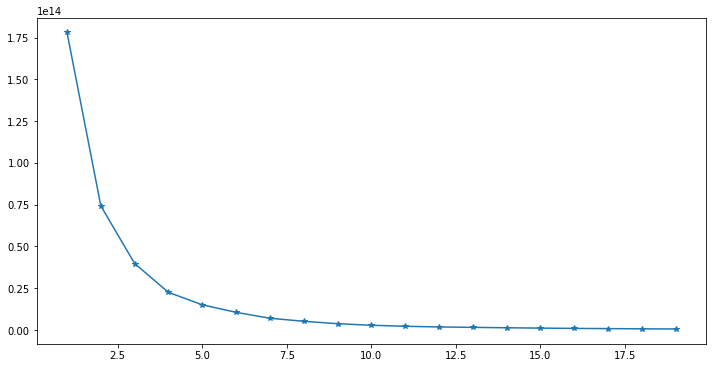

In [16]:
# 給出中心數範圍(1, 20)
cluster_range = range( 1, 20 )
cluster_errors = []

# 做20次, 把誤差結果放進cluster_errors list裡
for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( user_feature_df )
    cluster_errors.append( clusters.inertia_ )

# 畫出'X=kmeans中心數, Y=誤差'的圖 
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker='*')

### 由圖看出分成三群最適當, 所以分成3群

In [17]:
# 分成三群
kMeans_3 = KMeans(3)
kMeans_3.fit(user_feature_df)

KMeans(n_clusters=3)

In [18]:
# 貼上 label
user_feature_df['label'] = kMeans_3.labels_
user_feature_df.head()

,recency,monetary_value,frequency,生鮮食品,冷凍食品,生活休閒,飲料零食,米油沖泡,服飾鞋包,日用百貨,...,八德區,復興區,桃園區,大溪區,新屋區,楊梅區,平鎮區,Male,Female,label
customer_id,,,,,,,,,,,,,,,,,,,,,
1,374,205050,1,59.0,28.0,101.0,53.0,107.0,23.0,54.0,...,0,0,0,0,0,0,0,0,1,0
2,374,740,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,1
3,374,230,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
4,374,152,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,1
5,374,328641,1,77.0,26.0,123.0,55.0,102.0,26.0,63.0,...,0,0,0,0,0,0,1,0,1,0


In [19]:
# 每個群的數值平均量 df
kmeans_3_df = user_feature_df.groupby('label').mean()
kmeans_3_df

,recency,monetary_value,frequency,生鮮食品,冷凍食品,生活休閒,飲料零食,米油沖泡,服飾鞋包,日用百貨,...,蘆竹區,八德區,復興區,桃園區,大溪區,新屋區,楊梅區,平鎮區,Male,Female
label,,,,,,,,,,,,,,,,,,,,,
0,56.052758,3.443256e+05,12.223022,45.872902,20.851319,78.817746,57.095923,90.016787,13.306954,44.393285,...,0.088729,0.107914,0.055156,0.083933,0.079137,0.088729,0.071942,0.050360,0.474820,0.525180
1,122.989215,3.933767e+04,2.654305,6.883822,3.075307,11.118448,8.418354,13.500473,1.843330,6.570293,...,0.071712,0.083444,0.073226,0.075875,0.084011,0.085147,0.077200,0.073226,0.501608,0.498392
2,3.500000,4.193963e+06,110.166667,486.500000,224.166667,815.500000,609.333333,939.000000,140.000000,478.166667,...,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.166667,0.333333,0.666667


In [20]:
# 輸出成果
# kmeans_3_df.to_csv('kmeans_result.csv', encoding='utf_8_sig')

# 畫圓餅圖(Label 0)

In [21]:
import matplotlib
import matplotlib.pyplot as plt

# import字型管理套件
from matplotlib.font_manager import FontProperties

# 指定使用字型和大小
myFont = FontProperties(fname='Microsoft Jhenghei.ttf', size=14)

In [22]:
# 種類的名稱list(觀察用)
list(kmeans_3_df.columns[3:15])

['生鮮食品',
 '冷凍食品',
 '生活休閒',
 '飲料零食',
 '米油沖泡',
 '服飾鞋包',
 '日用百貨',
 '美妝護理',
 '母嬰保健',
 '大小家電',
 '傢俱寢飾',
 '3C']

In [23]:
# 種類的數值list(觀察用)
list(kmeans_3_df.loc[0][3:15].values)

[45.87290167865707,
 20.851318944844124,
 78.81774580335731,
 57.09592326139089,
 90.0167865707434,
 13.30695443645084,
 44.39328537170264,
 38.50119904076739,
 5.045563549160671,
 12.011990407673862,
 3.258992805755396,
 3.6906474820143886]

In [24]:
# 種類類型
category = list(kmeans_3_df.columns[3:15])

# 種類購買個數
count = list(kmeans_3_df.loc[0][3:15].values)

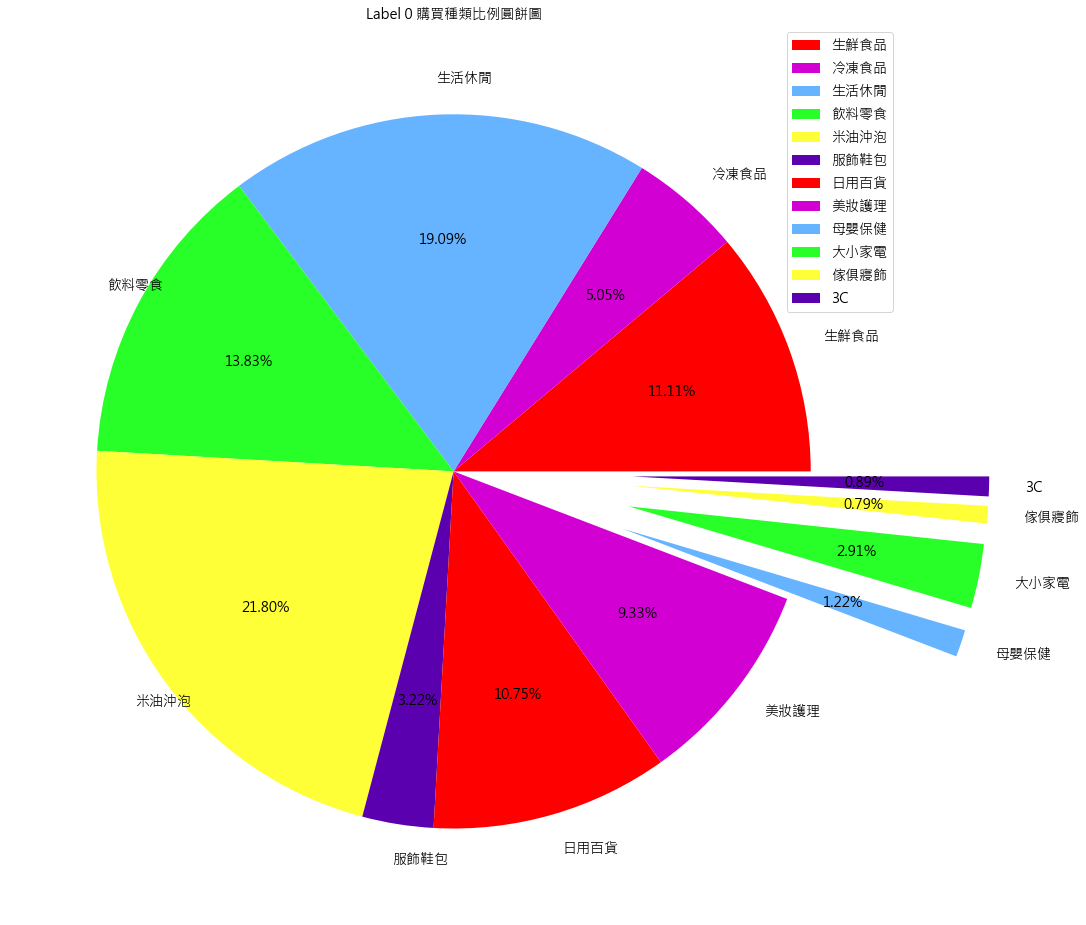

In [25]:
# 設定顏色 (超過會重複這幾個顏色)
color = ['#ff0000', '#d200d2', '#66b3ff', '#28ff28', '#ffff37', '#5b00ae']

# 設定圓餅圖大小
plt.figure(figsize=(16,20))

# 依據類別數量，分別設定要突出的距離
separeted = (0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5)   

# 設定圓餅圖屬性
pictures,category_text,percent_text = plt.pie(

        count,                           # 數值

        colors = color,                   # 指定圓餅圖的顏色

        labels = category,                # 分類的標記

        autopct = "%0.2f%%",              # 四捨五入至小數點後面位數

        explode = separeted,              # 設定分隔的區塊位置

        pctdistance = 0.65,               # 數值與圓餅圖的圓心距離

        radius = 1,                     # 圓餅圖的半徑，預設是1

        center = (10,0),                 # 圓餅圖的圓心座標

        shadow=False)                     # 是否使用陰影

# 把每個分類設成中文字型
for t in category_text:
    t.set_fontproperties(myFont)

# 把每個數值設成中文字型
for t in percent_text:
    t.set_fontproperties(myFont)

#設定legnd的位置
plt.legend(loc = 'upper right',prop=myFont)

# 設定圖片標題，以及指定字型設定，x代表與圖案最左側的距離，y代表與圖片的距離
plt.title("Label 0 購買種類比例圓餅圖", fontproperties=myFont, x=0.5, y=1)

# 畫出圓餅圖
plt.show()

## 可看出 label 0 最常買的是米油沖泡跟生活休閒